# What are the end-to-end travel times for each bus route in the city?
The following sections look to answer the question above and the subquestions of...
- On average, how long does an individual have to wait for a bus (on time vs. delayed)? [What is the average delay time of all routes across the entire city?] These 2 questions are grouped as they're essentially asking the same thing.
- What is the average delay time of the target bus routes (22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14 - from Livable Streets report)?

In [ ]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

file_pattern = "data/MBTA-Bus-Arrival-Departure-Times_2022-*.csv"
csv_files = sorted(glob.glob(file_pattern))

print(csv_files)

[]


In [55]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"])

        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.strftime("%H:%M:%S")
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.strftime("%H:%M:%S")

        chunk["scheduled"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["scheduled"])
        chunk["actual"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["actual"])

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)

In [56]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)
final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("incorrect_final_summary.csv", index=False)


ValueError: No objects to concatenate

### Data Visualization for Obvious Outliers
We do basic graphing to see if there were any with the calculations and see that there are obvious outliers. Rather than throwing them away, we should try to see what's causing this

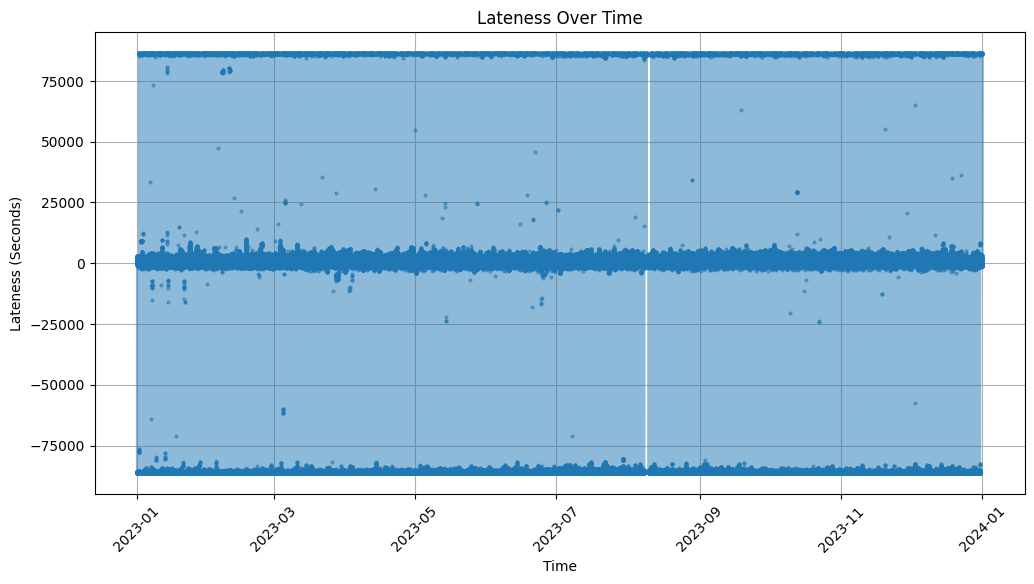

In [ ]:
lateness_df = pd.DataFrame({"timestamp": timestamps, "lateness": lateness_over_time})
lateness_df = lateness_df.sort_values(by="timestamp")
plt.figure(figsize=(12, 6))
plt.plot(lateness_df["timestamp"], lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Lateness Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We grab the original indices from the original dataset to see what may be causing this

In [ ]:
outliers_df = lateness_df[lateness_df["lateness"].abs() > 20000].reset_index()
outliers_df

,index,timestamp,lateness
0,30962,2023-01-01 00:00:02,-85918.0
1,9599,2023-01-01 00:00:03,-85977.0
2,39746,2023-01-01 00:00:07,-86213.0
3,18058,2023-01-01 00:00:08,-86092.0
4,31632,2023-01-01 00:00:16,-86264.0
...,...,...,...
48636,27086080,2023-12-31 23:59:18,86298.0
48637,27083576,2023-12-31 23:59:32,86132.0
48638,27053192,2023-12-31 23:59:44,86324.0
48639,27086081,2023-12-31 23:59:45,86265.0


We see from below that the reason for the outliers was for trains that was expected arrive right before midnight and arrived right after midnight. This causes a difference of near 86400 (number of seconds in a day) depending on when it arrived which lines up with the graph and table shown above.

In [ ]:
outlier_indices = set(outliers_df["index"].values)
original_outlier_rows = [] 
for csv_file in csv_files:
    print(f"Processing {csv_file} for outliers in chunks...")

    for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
        # Identify rows in the chunk that match the outlier indices
        matching_rows = chunk.loc[chunk.index.isin(outlier_indices)]

        if not matching_rows.empty:
            original_outlier_rows.append(matching_rows)

final_outlier_data = pd.concat(original_outlier_rows, ignore_index=True)
final_outlier_data

Processing data/MBTA-Bus-Arrival-Departure-Times_2023-01.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-02.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-03.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-04.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-05.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-06.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-07.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-08.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-09.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-10.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-Times_2023-11.csv for outliers in chunks...
Processing data/MBTA-Bus-Arrival-Departure-

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2023-01-01,01,Inbound,58061792.0,59,Wasma,7,Midpoint,Headway,1900-01-02T00:00:00Z,1900-01-01T23:52:19Z,960.0,793.0
1,2023-01-01,01,Inbound,58061792.0,62,Melwa,8,Midpoint,Headway,1900-01-02T00:04:00Z,1900-01-01T23:55:56Z,960.0,657.0
2,2023-01-01,01,Inbound,58061792.0,64,nubn,9,Endpoint,Headway,1900-01-02T00:05:00Z,1900-01-01T23:56:48Z,960.0,661.0
3,2023-01-01,08,Inbound,58061955.0,64,nubn,5,Midpoint,Schedule,1900-01-02T00:00:00Z,1900-01-01T23:58:13Z,NaN,NaN
4,2023-01-01,08,Outbound,58061952.0,64,nubn,6,Midpoint,Schedule,1900-01-01T23:58:00Z,1900-01-02T00:02:59Z,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,2023-12-31,SL1,Outbound,61821420.0,12005,twtns,5,Midpoint,Headway,1900-01-01T19:37:00Z,1900-01-01T19:38:59Z,600.0,718.0
39782,2023-12-31,SL2,Inbound,61821710.0,74615,wtcst,3,Midpoint,Headway,1900-01-01T17:11:00Z,NaN,900.0,NaN
39783,2023-12-31,SL4,Outbound,61822309.0,55,Wasma,4,Midpoint,Headway,1900-01-01T20:33:00Z,1900-01-01T20:38:35Z,900.0,NaN
39784,2023-12-31,SL4,Outbound,61822309.0,64,nubn,5,Endpoint,Headway,1900-01-01T20:37:00Z,1900-01-01T20:40:07Z,900.0,NaN


We write a refined version of data extraction of the above steps to handle the case where the days are different

In [ ]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"]).dt.tz_localize(None)
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.tz_localize(None)
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.tz_localize(None)

        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)

        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-01.csv in chunks...


Processing 2023-01: 5it [00:16,  3.35s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-02.csv in chunks...


Processing 2023-02: 5it [00:14,  2.82s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-03.csv in chunks...


Processing 2023-03: 5it [00:19,  3.84s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-04.csv in chunks...


Processing 2023-04: 5it [00:17,  3.50s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-05.csv in chunks...


Processing 2023-05: 5it [00:19,  3.85s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-06.csv in chunks...


Processing 2023-06: 5it [00:19,  3.84s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-07.csv in chunks...


Processing 2023-07: 5it [00:19,  3.82s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-08.csv in chunks...


Processing 2023-08: 5it [00:19,  3.95s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-09.csv in chunks...


Processing 2023-09: 5it [00:20,  4.18s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-10.csv in chunks...


Processing 2023-10: 5it [00:22,  4.54s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-11.csv in chunks...


Processing 2023-11: 5it [00:21,  4.37s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-12.csv in chunks...


Processing 2023-12: 5it [00:21,  4.24s/it]


In [ ]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)
final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("unfiltered_final_summary.csv", index=False)


### Outlier Analysis (Post Data Cleaning)

If we look at the new outliers, we see that many outliers are grouped together, if we see that a bus is late by 10 hours (most likely due to maintenance, accidents, etc), it will cause all other buses on the same route to be equally late, signifying that the schedule was most likely shifted but was not reflected in the database as the intervals between the late buses remain similar. For these buses, I decided to arbitrarily not mark any bus arrivals later or earlier than an hour to be accidents or schedule shifts (perhaps we can look for a better outlier detection model). But we also see certain routes have much more outliers than others

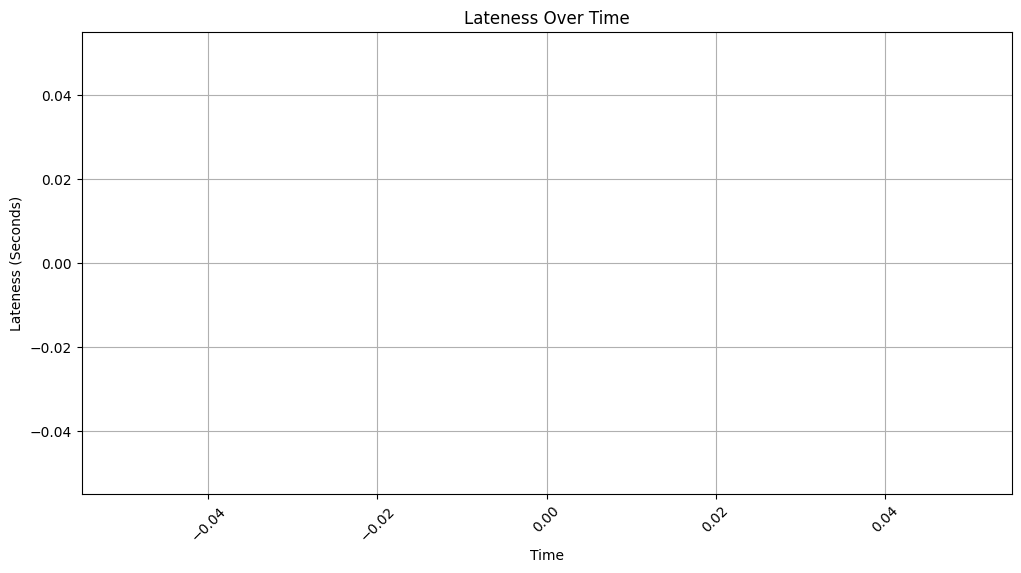

In [57]:
lateness_df = pd.DataFrame({"timestamp": timestamps, "lateness": lateness_over_time})
lateness_df = lateness_df.sort_values(by="timestamp")
plt.figure(figsize=(12, 6))
plt.plot(lateness_df["timestamp"], lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Lateness Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [58]:
outliers_df = lateness_df[lateness_df["lateness"].abs() > 3600].reset_index()
outlier_indices = set(outliers_df["index"].values)
original_outlier_rows = [] 
for csv_file in csv_files:
    print(f"Processing {csv_file} for outliers in chunks...")

    for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
        # Identify rows in the chunk that match the outlier indices
        matching_rows = chunk.loc[chunk.index.isin(outlier_indices)]

        if not matching_rows.empty:
            original_outlier_rows.append(matching_rows)

final_outlier_data = pd.concat(original_outlier_rows, ignore_index=True)
final_outlier_data

ValueError: No objects to concatenate

In [ ]:
outliers_per_route = final_outlier_data["route_id"].value_counts().reset_index()
outliers_per_route.columns = ["route_id", "outlier_count"]
outliers_per_route.head(15)

,route_id,outlier_count
0,743,440
1,66,399
2,SL1,385
3,28,338
4,111,330
5,77,266
6,01,266
7,23,256
8,57,243
9,22,221


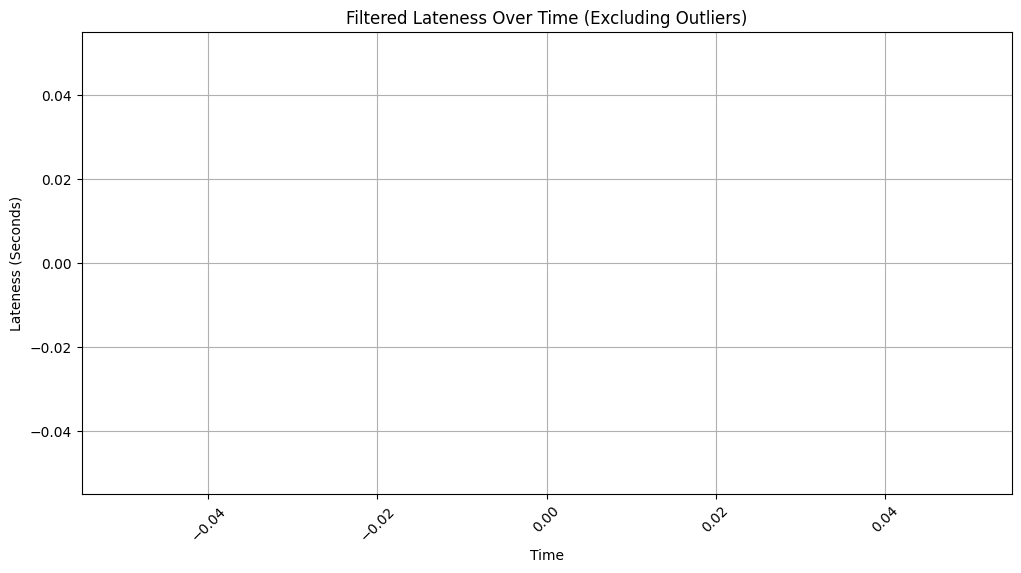

In [59]:
filtered_lateness_df = lateness_df[lateness_df["lateness"].abs() <= 3600]

plt.figure(figsize=(12, 6))
plt.plot(filtered_lateness_df["timestamp"], filtered_lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Filtered Lateness Over Time (Excluding Outliers)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [60]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
outlier = 3600 # 1 hour in seconds
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"]).dt.tz_localize(None)
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.tz_localize(None)
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.tz_localize(None)

        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)

        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()
        chunk = chunk[chunk["lateness"].abs() <= outlier]

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


In [61]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)

final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("final_summary.csv", index=False)


ValueError: No objects to concatenate

In [ ]:
citywide_avg_lateness = final_summary["lateness"].sum() / final_summary["size"].sum()

target_routes = ["22", "29", "15", "45", "28", "44", "42", "17", "23", "31", "26", "111", "24", "33", "14"]

target_routes_summary = final_summary[final_summary["route_id"].isin(target_routes)]

target_routes_avg_lateness = (target_routes_summary["average_lateness"] * target_routes_summary["size"]).sum() / target_routes_summary["size"].sum()

print(citywide_avg_lateness)

route_avg_wait_time = final_summary.groupby("route_id", as_index=False)["average_lateness"].mean()
target_routes_avg_wait_time = route_avg_wait_time[route_avg_wait_time["route_id"].isin(target_routes)]

target_routes_avg_wait_time

243.42730186850116


,route_id,average_lateness
15,111,160.259107
27,14,241.300362
28,15,209.260390
30,17,297.534264
46,22,333.710986
51,23,268.734001
55,24,281.822288
58,26,103.357212
59,28,334.343715
60,29,520.062975


# Can we chart changes over TIME?
The section below looks to answer this question

In [ ]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

file_pattern = "data/MBTA-Bus-Arrival-Departure-Times_2022-*.csv"
csv_files = sorted(glob.glob(file_pattern))

print(csv_files)

[]


We need stop information such as lat and long for each station so we download data from here: https://www.mbta.com/developers/gtfs

In [63]:
stops = pd.read_csv("stops.csv")
stops

FileNotFoundError: [Errno 2] No such file or directory: 'stops.csv'

In [ ]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
outlier = 3600 # 1 hour in seconds
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"]).dt.tz_localize(None)
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.tz_localize(None)
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.tz_localize(None)

        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)

        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()
        chunk = chunk[chunk["lateness"].abs() <= outlier]

        total_lateness_per_route = chunk.groupby("stop_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("stop_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-01.csv in chunks...


Processing 2023-01: 5it [00:17,  3.52s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-02.csv in chunks...


Processing 2023-02: 5it [00:15,  3.06s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-03.csv in chunks...


Processing 2023-03: 5it [00:18,  3.79s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-04.csv in chunks...


Processing 2023-04: 5it [00:18,  3.77s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-05.csv in chunks...


Processing 2023-05: 5it [00:19,  3.91s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-06.csv in chunks...


Processing 2023-06: 5it [00:20,  4.11s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-07.csv in chunks...


Processing 2023-07: 5it [00:19,  3.87s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-08.csv in chunks...


Processing 2023-08: 5it [00:19,  3.98s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-09.csv in chunks...


Processing 2023-09: 5it [00:21,  4.24s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-10.csv in chunks...


Processing 2023-10: 5it [00:23,  4.64s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-11.csv in chunks...


Processing 2023-11: 5it [00:26,  5.26s/it]


Processing data/MBTA-Bus-Arrival-Departure-Times_2023-12.csv in chunks...


Processing 2023-12: 5it [00:23,  4.75s/it]


In [ ]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)

final_total_lateness = final_total_lateness_chunks.groupby(["stop_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["stop_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["stop_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("final_stop_summary.csv", index=False)

In [64]:
stops[["stop_id", "stop_lat", "stop_lon"]]

,stop_id,stop_lat,stop_lon
0,1,42.330957,-71.082754
1,10,42.330555,-71.068787
2,10000,42.355692,-71.062911
3,10003,42.331591,-71.076237
4,10005,42.335017,-71.071280
...,...,...,...
10237,node-wtcst-paidlobbycenter,NaN,NaN
10238,node-wtcst-wtcbstairs-landing,NaN,NaN
10239,node-wtcst-wtcbstairs-lobby,NaN,NaN
10240,node-wtcst-wtctstairs-landing,NaN,NaN


In [65]:
stops["stop_id"] = stops["stop_id"].astype(str)
final_summary["stop_id"] = final_summary["stop_id"].astype(str)

final_summary_with_coords = final_summary.merge(
    stops[["stop_id", "stop_lat", "stop_lon"]], 
    on="stop_id", 
    how="left"
)
final_summary_with_coords



,stop_id,month,lateness,size,average_lateness,stop_lat,stop_lon
0,2,2023-01,664269.0,3037,218.725387,42.332324,-71.081252
1,2,2023-02,545882.0,2656,205.527861,42.332324,-71.081252
2,2,2023-03,718214.0,3072,233.793620,42.332324,-71.081252
3,2,2023-04,993026.0,3009,330.018611,42.332324,-71.081252
4,2,2023-05,868400.0,2883,301.214013,42.332324,-71.081252
...,...,...,...,...,...,...,...
13236,883321,2023-08,66161.0,196,337.556122,42.376033,-71.234936
13237,883321,2023-09,76702.0,162,473.469136,42.376033,-71.234936
13238,883321,2023-10,95603.0,184,519.581522,42.376033,-71.234936
13239,883321,2023-11,87356.0,184,474.760870,42.376033,-71.234936


In [66]:
final_summary_with_coords.to_csv("final_stop_summary.csv", index=False)

We see the results through the map here on arcgis for 2024 data. https://bucas.maps.arcgis.com/apps/mapviewer/index.html?webmap=9f60b58427e94c3991bba8cbce9f61ff

# Modeling the Data

## Clustering

Since we weren't given a explicit means to model our data, we'll be taking creative liberties on what type of model we should use. We could have used one of many different ideas such as prediciting the next delay for a bus stop given a certain number of previous delays, but given the nature of the project, which looks to analyze service performance trends, we can look to identify areas that could use more attention by the MBTA to promote equity. One of the main ways to do this is by identifying areas and stops in Boston that are disproportionately affected by poor bus service. We can use clustering such as KMeans or DBScan to see which areas have unusually poor service. We can then combine this with census data to see which people are being affected the most as well.

## K-Means Clustering

In [67]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

file_path = "final_stop_summary.csv"
df = pd.read_csv(file_path)

df.head()

,stop_id,month,lateness,size,average_lateness,stop_lat,stop_lon
0,2,2023-01,664269.0,3037,218.725387,42.332324,-71.081252
1,2,2023-02,545882.0,2656,205.527861,42.332324,-71.081252
2,2,2023-03,718214.0,3072,233.793620,42.332324,-71.081252
3,2,2023-04,993026.0,3009,330.018611,42.332324,-71.081252
4,2,2023-05,868400.0,2883,301.214013,42.332324,-71.081252


We first need to aggregate each month for each stop so that we can get the average_lateness for each stop for the entire year

In [68]:
stop_total_lateness = defaultdict(int)
stop_total_size = defaultdict(int)
stop_lat = {}
stop_long = {}
for _, row in df.iterrows():
    stop_id = row['stop_id']
    stop_total_lateness[stop_id] += row['lateness']
    stop_total_size[stop_id] += row['size']
    if stop_id not in stop_lat:
        stop_lat[stop_id] = row['stop_lat']
        stop_long[stop_id] = row['stop_lon']

stop_agg_df = pd.DataFrame({
        "stop_id": list(stop_total_lateness.keys()),
        "average_lateness": [stop_total_lateness[k] / stop_total_size[k] for k in stop_total_lateness.keys()],
        "stop_lat": [stop_lat[k] for k in stop_total_lateness.keys()],
        "stop_lon": [stop_long[k] for k in stop_total_lateness.keys()]
    })

output_file_path = "stop_agg_lateness.csv"
stop_agg_df.to_csv(output_file_path, index=False)

stop_agg_df


,stop_id,average_lateness,stop_lat,stop_lon
0,2,268.159055,42.332324,-71.081252
1,5,169.168040,42.336339,-71.077070
2,7,472.467989,42.333043,-71.081108
3,8,125.461698,42.331202,-71.070724
4,13,292.523716,42.329962,-71.057625
...,...,...,...,...
1139,96459,305.960437,42.278688,-71.116096
1140,98618,135.854733,42.145831,-71.252940
1141,99832,287.863636,42.251984,-71.168849
1142,99991,147.819197,42.308378,-71.115619


In [69]:
X = stop_agg_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
X["average_lateness"] = (X["average_lateness"] - X["average_lateness"].mean()) / X["average_lateness"].std()
X = X.dropna()

inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [70]:
nan_summary = stop_agg_df.isna().sum()
nan_summary

stop_id              0
average_lateness     0
stop_lat            33
stop_lon            33
dtype: int64

In [71]:
stop_agg_df_cleaned = stop_agg_df.dropna(subset=["stop_lat", "stop_lon"])

X = stop_agg_df_cleaned[["stop_lat", "stop_lon", "average_lateness"]].copy()
X["average_lateness"] = (X["average_lateness"] - X["average_lateness"].mean()) / X["average_lateness"].std()

cost = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)


We see that there are stops with no stop_lat and stop_lon. After browsing through the data, there are stop_id's on the stop_agg_lateness.csv that don't show up on the stops.csv. We have no idea why there is no data on this stop on stops.csv. We notice that some of these stops in the stop_agg_lateness.csv only go up to a certain month i.e. (Jan-Apr). It is most likely that the stop is no longer being used and not being included in the stops.csv so we decide to remove the stops that don't include the coordinates from our dataset as we assume that these are stops that no longer exist (we could be wrong on this).

/tmp/ipykernel_19793/2259248140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_agg_df_cleaned["cluster"] = kmeans.fit_predict(X)


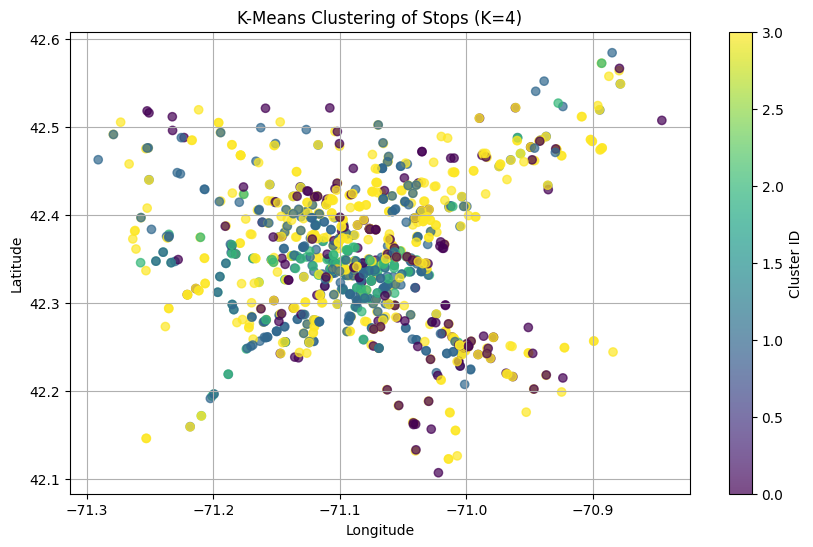

In [72]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
stop_agg_df_cleaned["cluster"] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    stop_agg_df_cleaned["stop_lon"], stop_agg_df_cleaned["stop_lat"], c=stop_agg_df_cleaned["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means Clustering of Stops (K={4})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


In [73]:
cluster_lateness_summary = stop_agg_df_cleaned.groupby("cluster")["average_lateness"].mean().reset_index()

cluster_lateness_summary

,cluster,average_lateness
0,0,41.838581
1,1,324.396034
2,2,525.128656
3,3,192.436814


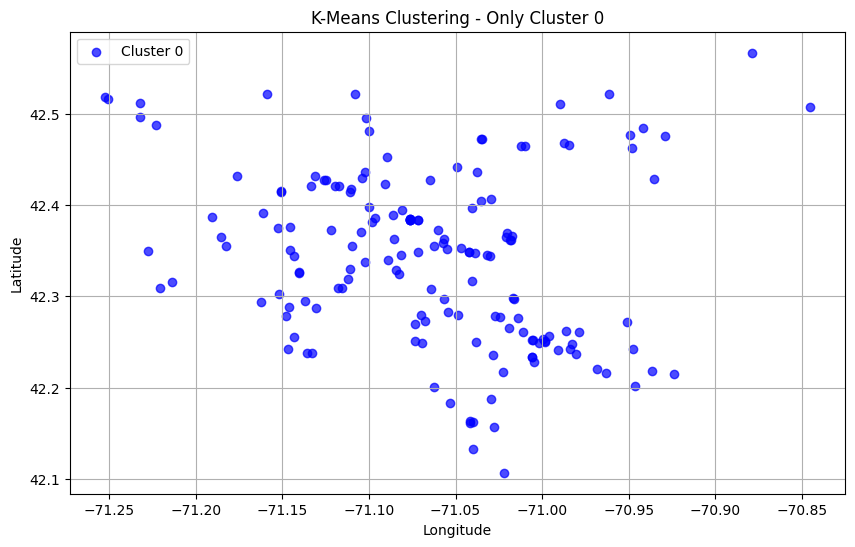

In [74]:
cluster_0_df = stop_agg_df_cleaned[stop_agg_df_cleaned["cluster"] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_0_df["stop_lon"], cluster_0_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()


It's also important to note that the K-Means clustering is done on lateness versus long/lat. Meaning since lateness has a much higher range, lateness will the be the primary factor contributing to the clusterings. This is not what we want as that's almost equivalent to getting only stops with high amounts of lateness. Instead we want to identify areas clumped on the map that have unusually high amounts of lateness so we normalize our data to ensure coordinates are being considered in the clusterings.

In [75]:
from sklearn.preprocessing import StandardScaler

X_original = stop_agg_df_cleaned[["stop_lat", "stop_lon", "average_lateness"]].copy()
print(X_original)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
print(X_scaled)

       stop_lat   stop_lon  average_lateness
0     42.332324 -71.081252        268.159055
1     42.336339 -71.077070        169.168040
2     42.333043 -71.081108        472.467989
3     42.331202 -71.070724        125.461698
4     42.329962 -71.057625        292.523716
...         ...        ...               ...
1139  42.278688 -71.116096        305.960437
1140  42.145831 -71.252940        135.854733
1141  42.251984 -71.168849        287.863636
1142  42.308378 -71.115619        147.819197
1143  42.376033 -71.234936        339.586599

[1111 rows x 3 columns]
[[-0.26663964  0.0293798   0.15625238]
 [-0.21643442  0.08498628 -0.52845316]
 [-0.25764897  0.03129451  1.56942568]
 ...
 [-1.27124421 -1.13536467  0.29254592]
 [-0.56607032 -0.42758532 -0.67611981]
 [ 0.27991576 -2.01409873  0.65030565]]


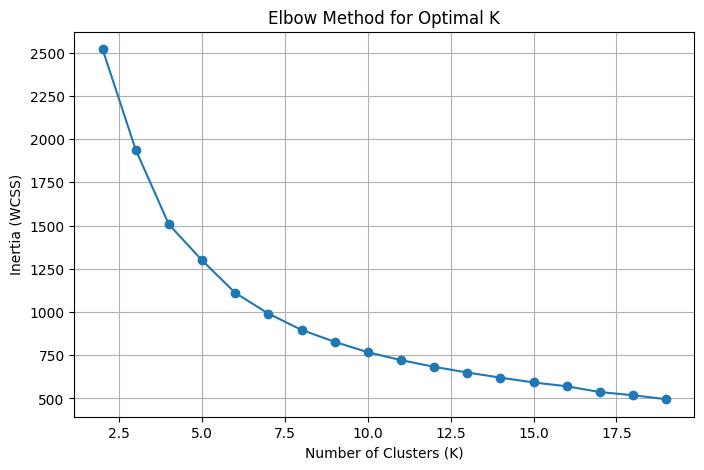

In [76]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

/home/kkey/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_19793/2006015415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_agg_df_cleaned["cluster"] = kmeans.fit_predict(X_scaled)


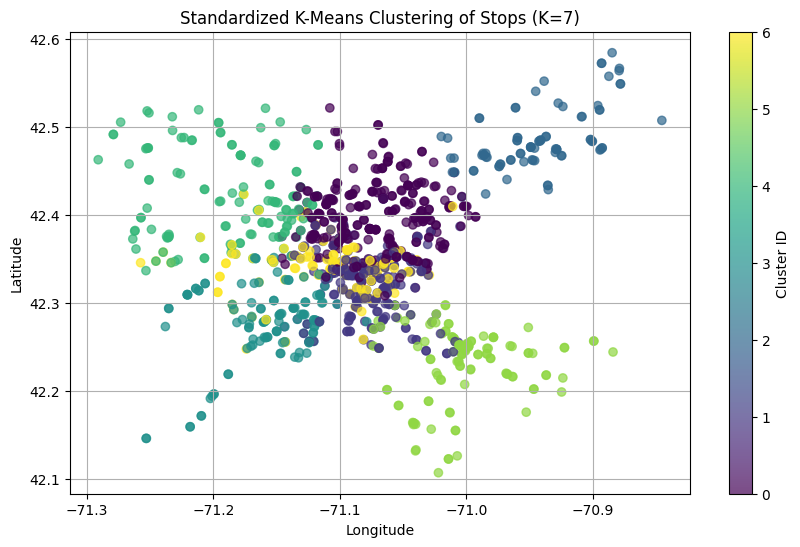

In [77]:

optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k)
stop_agg_df_cleaned["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    stop_agg_df_cleaned["stop_lon"], stop_agg_df_cleaned["stop_lat"], c=stop_agg_df_cleaned["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Standardized K-Means Clustering of Stops (K={optimal_k})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


We can now clearly see longitutde and latitude playing a big role as there is more separation of and clustering of assignments on the graph compared to the first graph.

In [78]:
cluster_lateness_summary = stop_agg_df_cleaned.groupby("cluster")["average_lateness"].mean().reset_index()

cluster_lateness_summary

,cluster,average_lateness
0,0,170.959479
1,1,311.675684
2,2,197.017083
3,3,206.925664
4,4,228.542647
5,5,130.369097
6,6,510.999327


We also see that cluster 3 now has an unusually high amount of average_lateness

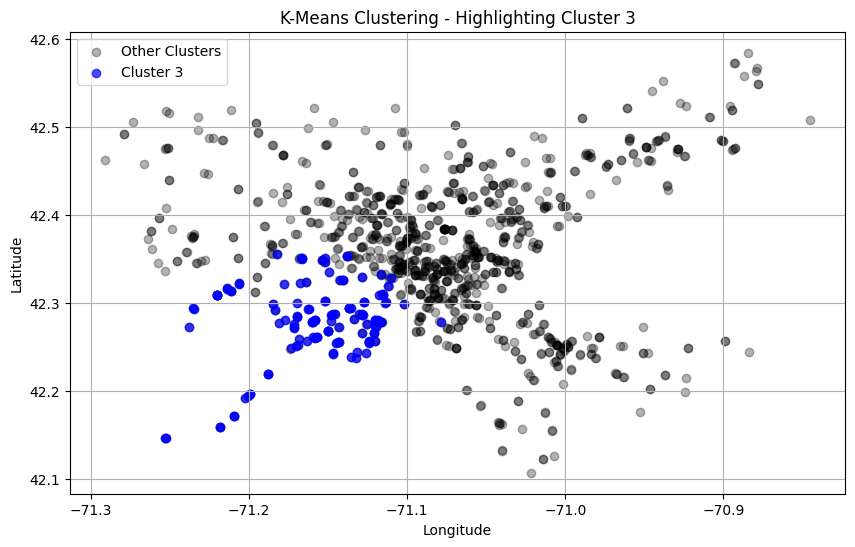

In [79]:
plt.figure(figsize=(10, 6))

plt.scatter(
    stop_agg_df_cleaned["stop_lon"], stop_agg_df_cleaned["stop_lat"], c="black", alpha=0.3, label="Other Clusters"
)

cluster_df = stop_agg_df_cleaned[stop_agg_df_cleaned["cluster"] == 3]
plt.scatter(
    cluster_df["stop_lon"], cluster_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 3"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Highlighting Cluster 3")
plt.legend()
plt.grid(True)

plt.show()


In [80]:
cluster_df.to_csv("kmeans_outlier.csv")

## DBScan

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csv_file = "stop_agg_lateness.csv"
df = pd.read_csv(csv_file)
df = df.dropna(subset=["stop_lat", "stop_lon"])
X = df[["stop_lat", "stop_lon", "average_lateness"]].copy()
X

,stop_lat,stop_lon,average_lateness
0,42.332324,-71.081252,268.159055
1,42.336339,-71.077070,169.168040
2,42.333043,-71.081108,472.467989
3,42.331202,-71.070724,125.461698
4,42.329962,-71.057625,292.523716
...,...,...,...
1139,42.278688,-71.116096,305.960437
1140,42.145831,-71.252940,135.854733
1141,42.251984,-71.168849,287.863636
1142,42.308378,-71.115619,147.819197


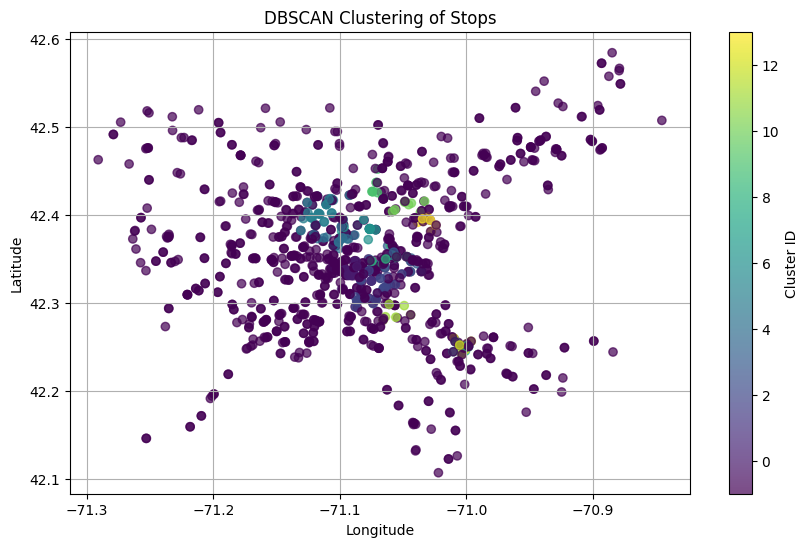

      stop_id  average_lateness   stop_lat   stop_lon  cluster
0           2        268.159055  42.332324 -71.081252        0
1           5        169.168040  42.336339 -71.077070        8
2           7        472.467989  42.333043 -71.081108        1
3           8        125.461698  42.331202 -71.070724       -1
4          13        292.523716  42.329962 -71.057625       -1
...       ...               ...        ...        ...      ...
1139    96459        305.960437  42.278688 -71.116096       -1
1140    98618        135.854733  42.145831 -71.252940       -1
1141    99832        287.863636  42.251984 -71.168849       -1
1142    99991        147.819197  42.308378 -71.115619       -1
1143   883321        339.586599  42.376033 -71.234936       -1

[1111 rows x 5 columns]


,cluster,average_lateness,num_stops
2,1,458.486486,7
3,2,349.006147,32
4,3,320.738919,14
11,10,261.435910,8
1,0,248.512276,32
8,7,248.107977,8
6,5,246.428184,30
0,-1,246.001654,898
5,4,199.213724,22
13,12,185.463006,7


In [82]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.2, min_samples=7)
df["cluster"] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["stop_lon"], df["stop_lat"], c=df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Stops")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()
print(df)

cluster_lateness_summary = df.groupby("cluster").agg(
    average_lateness=("average_lateness", "mean"),
    num_stops=("stop_id", "count")
).reset_index()

cluster_lateness_summary = cluster_lateness_summary.sort_values(by="average_lateness", ascending=False)

cluster_lateness_summary

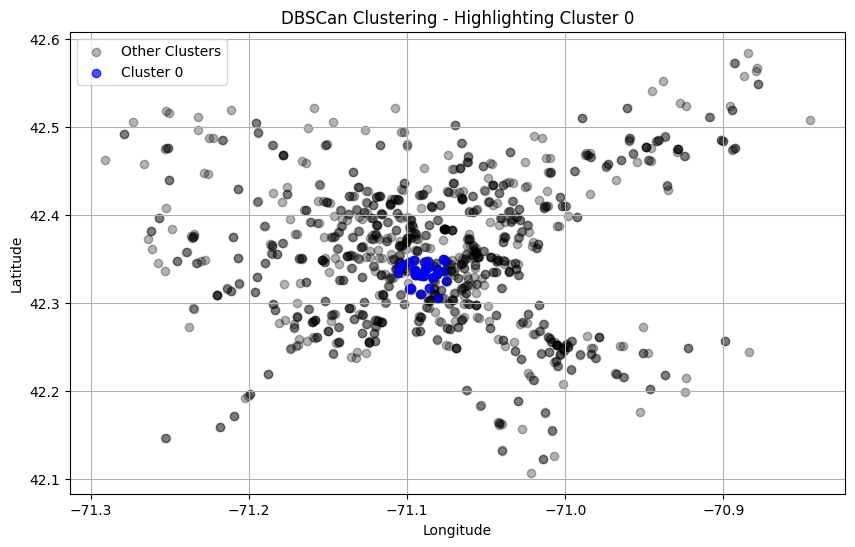

In [83]:
plt.figure(figsize=(10, 6))

plt.scatter(
    df["stop_lon"], df["stop_lat"], c="black", alpha=0.3, label="Other Clusters"
)

cluster_df = df[df["cluster"] == 0]
plt.scatter(
    cluster_df["stop_lon"], cluster_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCan Clustering - Highlighting Cluster 0")
plt.legend()
plt.grid(True)

plt.show()


In [84]:
cluster_df.to_csv("dbscan_outlier.csv")